In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/'My Drive'/music-interpolation/
%ls

/content/drive/My Drive/music-interpolation
base.py
data/
decoderOld.png
decoder.png
encoderOld.png
encoder.png
GUI/
LSTMEncoderDecoder.ipynb
LSTMSeparateEncoderDecoder-oneHot-gen.ipynb
LSTMSeparateEncoderDecoder-oneHot.ipynb
LSTMSeparateEncoderDecoder-pianoRoll-gen-FINAL.ipynb
LSTMSeparateEncoderDecoder-pianoRoll-gen-FINAL-TEST1.ipynb
LSTMSeparateEncoderDecoder-pianoRoll-gen-FINAL-TEST.ipynb
LSTMSeparateEncoderDecoder-pianoRoll-gen.ipynb
LSTMSeparateEncoderDecoder-pianoRoll.ipynb
LSTMSeparateEncoderDecoder.py
LSTMSeparateVariationalEncoderDecoder-pianoRoll-gen-FINAL-TEST.ipynb
midiScripts/
modelOld.png
model.png
models/
notes_1.txt
notes.txt
out/
plik_deocder.h5
plik_encoder.h5
preprocess.py
__pycache__/
README.md
SimpleLSTMAutoencoder.ipynb
trainingsHistory/


In [0]:
from numpy import array
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Activation, Reshape, Masking
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pydot
import graphviz
from midiScripts.full_piano_roll_converter import FullPianoRollConverter
import base

%load_ext autoreload
%autoreload 2

In [5]:
pip install --upgrade tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 33.1MB/s 
     |████████████████████████████████| 450kB 68.4MB/s 
     |████████████████████████████████| 81kB 14.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

In [4]:
tf.__version__

'2.0.0'

In [0]:
fprc = FullPianoRollConverter()

In [0]:
# updatable plot for live loss value observation
# a minimal example (sort of)

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('binary_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.legend()
        plt.show();
        
plot = PlotLosses()

In [0]:
class Autoencoder():
    
    def __init__(self, chords_len):
        self.chords_len = chords_len # length of one-hot encoded vector representing one note
        self.seq_window = 16 # length of notes in one music sample
        self.lstm_state_2 = 2048 # length of wide lstm cells output
        self.lstm_state_1 = 4048 # length of narrow lstm cells output

    
        self.encoder, self.decoder, self.model = self.autoencoder_model()
        
    def autoencoder_model(self):
    
        # # define encoder
        enc_inputs1 = Input(shape=(None, 3, self.chords_len))
        enc_inputs2 = Reshape((-1, self.chords_len * 3), input_shape=(None, 3, self.chords_len))(enc_inputs1)
        mask = Masking(mask_value=0., input_shape=(None, 3 * self.chords_len))(enc_inputs2)
        # enc_output1 = LSTM(self.lstm_state_1, return_sequences = True, return_state = False)(mask)
        enc_output = LSTM(self.lstm_state_2, return_sequences = False, return_state = False)(mask) #(enc_output1)

        encoder = Model(enc_inputs1, enc_output, name="encoder")

        # define decoder
        dec_inputs = Input(shape=encoder.output.shape[1:])
        dec_inputs_exp = tf.expand_dims(dec_inputs, axis=1)
        dec_repeated = tf.tile(dec_inputs_exp, [1, tf.shape(enc_inputs1)[1], 1])
#         dec_repeated= RepeatVector()(dec_inputs) # to moze pogorszyc dzialanie modelu
        dec_lstm = LSTM(self.lstm_state_2, return_sequences=True)(dec_repeated)
        # dec_lstm = LSTM(self.lstm_state_1, return_sequences=True)(dec_lstm1)
        play_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="play_output")(dec_lstm)
        repeat_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="repeat_output")(dec_lstm)
        volume_output = TimeDistributed(Dense(self.chords_len, activation = 'sigmoid'), name="volume_output")(dec_lstm)
        
        concat_output = tf.stack([play_output, repeat_output, volume_output], axis=-2)
        
        decoder = Model(inputs=[dec_inputs, enc_inputs1], outputs=concat_output, name="decoder")
        
        print(concat_output)
        
        model_encoded = encoder(enc_inputs1)
        model_decoded = decoder([model_encoded, enc_inputs1])
        model = Model(enc_inputs1, outputs=model_decoded, name="autoencoder")
        
        return encoder, decoder, model

    def load_my_model(self, model_weights):
        # load previously saved weights to the model
        self.model.load_weights(model_weights)

#         self.model.layers[1].save_weights("plik_encoder.h5")
#         self.model.layers[2].save_weights("plik_deocder.h5")

#         self.encoder.load_weights("plik_encoder.h5")
#         self.decoder.load_weights("plik_deocder.h5")

In [0]:
class Test:  
    def perform_test_with_piano_roll(self, model, encoder, decoder):
#         x_test = fprc.convert_midi_to_neural_network_input(base.get_test_data_dir() + "*.mid", names_to_save = "test")
#        x_train = pre.convert_midi_to_neural_network_input(base.get_training_data_dir() + "*.mid")
#        x_validate = pre.convert_midi_to_neural_network_input(base.get_validation_data_dir() + "*.mid")
        
        # For testing purposes
#         fprc.print_test_file_names()
        
        x_test = tf.data.Dataset.from_generator(lambda:  fprc.samples_generator_for_nn_training(base.get_test_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape( [None, 3, len(fprc)]))
        x_test = x_test.padded_batch(10, padded_shapes = ([None, 3, len(fprc)]))
        
        encoded_pred = encoder.predict(x_test)
        
        decoded = decoder.predict(encoded_pred)
        
        print(type(decoded))
        print(len(decoded))
        print(len(decoded[0]))
        print(len(decoded[1]))
        print(len(decoded[2]))
        print(len(decoded[0][0]))
        print(decoded)
        
        model_output = model.predict(x_test, verbose=0)
        
#         fprc.convert_neural_network_output_to_midi(model_output, base.get_neural_network_output_dir(), "test")
        

In [0]:
# set file from which you want to load weights for your model, or where you want to save weights durring nn training
current_model = 'models/LSTMSeparateEncoder-Decoder_20_01_13_H1300_pianoRoll_final_4048_2048.h5'

In [9]:
print(len(fprc))

89


In [10]:
autoencoder = Autoencoder(len(fprc))

Tensor("stack:0", shape=(None, None, 3, 89), dtype=float32)


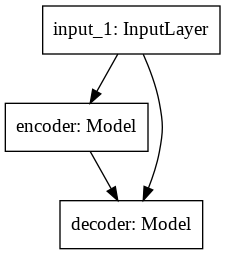

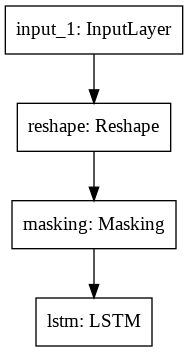

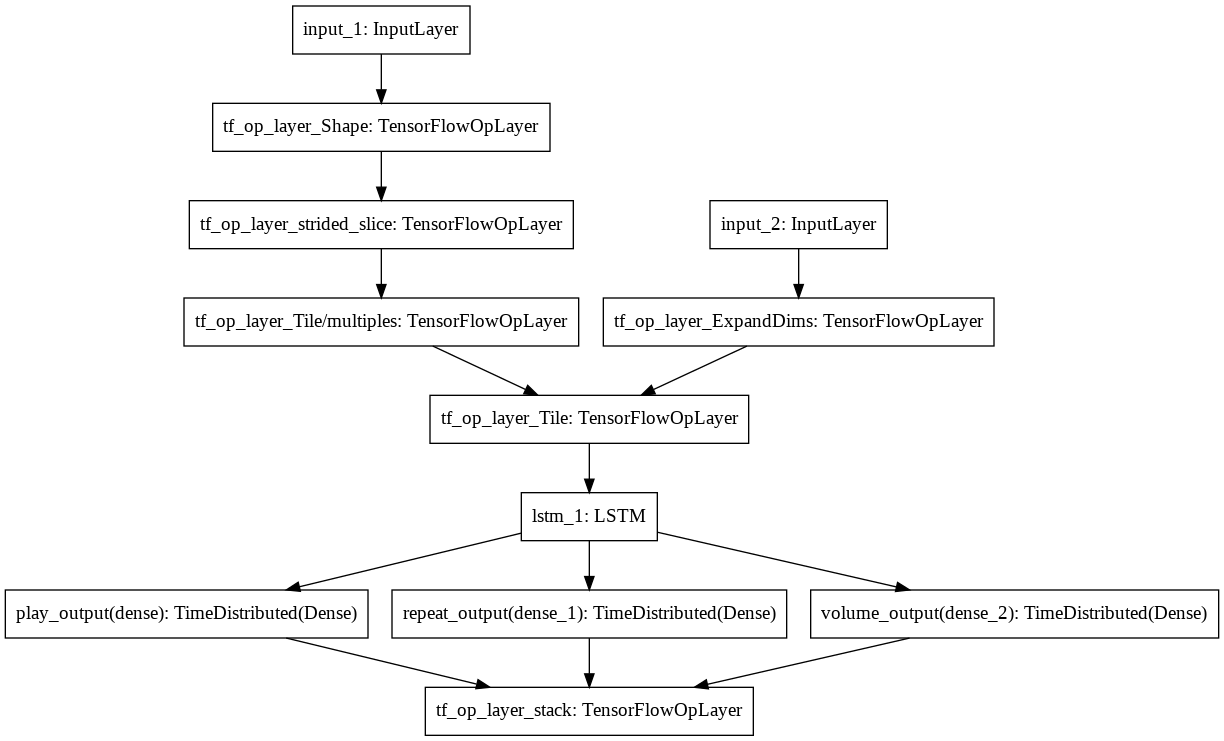

In [13]:
from IPython.display import display 
display(plot_model(autoencoder.model, to_file='model.png'))
display(plot_model(autoencoder.encoder, to_file='encoder.png'))
display(plot_model(autoencoder.decoder, to_file='decoder.png'))

In [0]:
# autoencoder.decoder.output_names

In [0]:
# autoencoder.model.output_names

In [14]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3, 89)]     0         
_________________________________________________________________
reshape (Reshape)            (None, None, 267)         0         
_________________________________________________________________
masking (Masking)            (None, None, 267)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 2048)              18972672  
Total params: 18,972,672
Trainable params: 18,972,672
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.decoder.summary()

In [0]:
# autoencoder.load_my_model(current_model)
(autoencoder.model).load_weights(current_model)

In [14]:
print(current_model)

models/LSTMSeparateEncoder-Decoder_20_01_13_H1300_pianoRoll_final_4048_2048.h5


In [0]:
# test = Test()
# test.perform_test_with_piano_roll(autoencoder.model, autoencoder.encoder, autoencoder.decoder)

In [0]:
def my_loss(y_true, y_pred):
    y_true_play, y_true_repeat, y_true_volume = tf.split(y_true, 3, axis=-2)
    y_pred_play, y_pred_repeat, y_pred_volume = tf.split(y_pred, 3, axis=-2)
    
    y_true_play, y_true_repeat, y_true_volume = (tf.squeeze(y_true_play, axis=-2),
                                                tf.squeeze(y_true_repeat, axis=-2),
                                                tf.squeeze(y_true_volume, axis=-2))
            
    y_pred_play, y_pred_repeat, y_pred_volume = (tf.squeeze(y_pred_play, axis=-2),
                                                tf.squeeze(y_pred_repeat, axis=-2),
                                                tf.squeeze(y_pred_volume, axis=-2))
    
    play_loss   = tf.reduce_sum(              K.binary_crossentropy(y_true_play,   y_pred_play),    axis=-1)
    print("play_loss: " + str(play_loss))
    repeat_loss = tf.reduce_sum(y_true_play * K.binary_crossentropy(y_true_repeat, y_pred_repeat),  axis=-1)
    print("repeat_loss: " + str(repeat_loss))
    volume_loss = tf.reduce_sum(y_true_play * tf.square(tf.subtract(y_true_volume, y_pred_volume)), axis=-1)
    print("volume_loss: " + str(volume_loss))
    
    return tf.reduce_mean(play_loss + repeat_loss + volume_loss)

In [0]:
# set optimizer with a given learning rate (lr)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [14]:
autoencoder.model.compile(optimizer=optimizer, 
                          loss=my_loss,
                          experimental_run_tf_function=False
                          )

play_loss: Tensor("loss/decoder_loss/Sum:0", shape=(None, None), dtype=float32)
repeat_loss: Tensor("loss/decoder_loss/Sum_1:0", shape=(None, None), dtype=float32)
volume_loss: Tensor("loss/decoder_loss/Sum_2:0", shape=(None, None), dtype=float32)


In [0]:
mc = ModelCheckpoint(current_model, monitor='loss', mode='min', verbose=1, save_best_only=True)

In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [0]:
def split_dataset(inputs):
    play_output, repeat_output, volume_output = tf.split(inputs, 3, axis=-2)
    
    play_output = tf.squeeze(play_output, axis=-2)
    repeat_output = tf.squeeze(repeat_output, axis=-2)
    volume_output = tf.squeeze(volume_output, axis=-2)
    
    return play_output, repeat_output, volume_output
# TODO: create dataset z tego ponizej dla train i validate jedna funkcja

In [18]:
x_dataset = tf.data.Dataset.from_generator(lambda:  fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape( [None, 3, len(fprc)]))
y_dataset = tf.data.Dataset.from_generator(lambda:  fprc.samples_generator_for_nn_training(base.get_training_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))

x_dataset = x_dataset.padded_batch(128, padded_shapes = ([None, 3, len(fprc)]))
y_dataset = y_dataset.padded_batch(128, padded_shapes = ([None, 3, len(fprc)]))

print(x_dataset)

# y_dataset = y_dataset.map(split_dataset)

data_x_y = tf.data.Dataset.zip((x_dataset, y_dataset))
# data_x_y = data_x_y.batch(128)


x_validate = tf.data.Dataset.from_generator(lambda: fprc.samples_generator_for_nn_training(base.get_validation_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))
y_validate = tf.data.Dataset.from_generator(lambda: fprc.samples_generator_for_nn_training(base.get_validation_data_dir()),
                                                    output_types = tf.float32,
                                                    output_shapes = tf.TensorShape([None, 3, len(fprc)]))

x_validate = x_validate.padded_batch(20, padded_shapes = tf.TensorShape([None, 3, len(fprc)]))
y_validate = y_validate.padded_batch(20, padded_shapes = tf.TensorShape([None, 3, len(fprc)]))

# y_validate = y_validate.map(split_dataset)

val_x_y = tf.data.Dataset.zip((x_validate, y_validate))
# val_x_y = val_x_y.batch(128)

<DatasetV1Adapter shapes: (None, None, 3, 89), types: tf.float32>


In [0]:
# y_true_play, y_true_repeat, y_true_volume = tf.split(y_true, 3, axis=-2)
# y_pred_play, y_pred_repeat, y_pred_volume = tf.split(y_pred, 3, axis=-2)
# y_true_play, y_true_repeat, y_true_volume = (tf.squeeze(y_true_play, axis=-2),
#                                             tf.squeeze(y_true_repeat, axis=-2),
#                                             tf.squeeze(y_true_volume, axis=-2))

# y_pred_play, y_pred_repeat, y_pred_volume = (tf.squeeze(y_pred_play, axis=-2),
#                                             tf.squeeze(y_pred_repeat, axis=-2),
#                                             tf.squeeze(y_pred_volume, axis=-2))

In [26]:
autoencoder.decoder.outputs

[<tf.Tensor 'stack:0' shape=(None, None, 3, 89) dtype=float32>]

In [27]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

In [0]:
import os 

if 'COLAB_TPU_ADDR' not in os.environ: 
  print('Not connected to TPU') 
else: 
  print("Connected to TPU") 

Not connected to TPU


In [0]:
# x_train = fprc.convert_midi_to_neural_network_input(base.get_training_data_dir() + "*.mid", names_to_save = "train")
# x_test = fprc.convert_midi_to_neural_network_input(base.get_test_data_dir() + "*.mid", names_to_save = "test")
# x_valid = fprc.convert_midi_to_neural_network_input(base.get_validation_data_dir() +  "*.mid", names_to_save = "validate")    

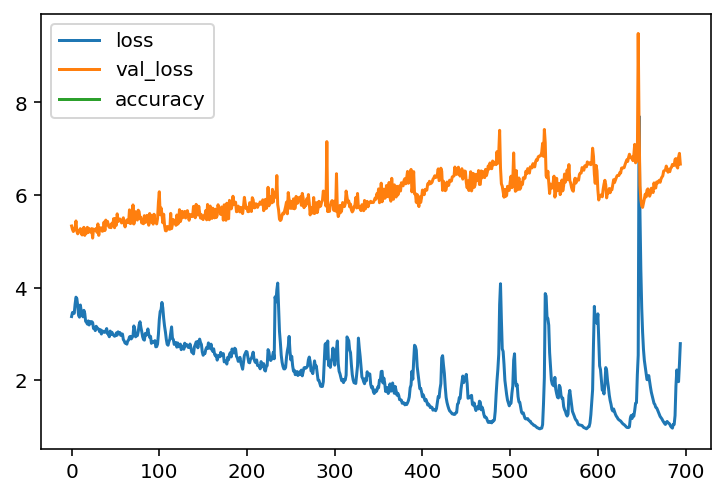


Epoch 00695: loss did not improve from 0.94899
12/12 [==============================] - 42s 3s/step - loss: 2.7747 - val_loss: 6.6667
Epoch 696/20000
 1/12 [=>............................] - ETA: 29s - loss: 2.7684

KeyboardInterrupt: ignored

In [0]:
# fit model
history = autoencoder.model.fit(data_x_y,
                                epochs=20000,
                                validation_data = val_x_y,
                                verbose=1,
#                                 steps_per_epoch = 7,
#                                 validation_steps = 1,
                                callbacks =[plot, mc]
                                )

In [0]:
for value in x_dataset.take(100):
  # print(value)
  print(value.shape)

(128, 70, 3, 89)
(128, 60, 3, 89)
(128, 68, 3, 89)
(128, 50, 3, 89)
(128, 62, 3, 89)
(128, 70, 3, 89)
(128, 68, 3, 89)
(104, 68, 3, 89)


In [0]:
enc_out = autoencoder.model.predict(x_dataset.take(1))
# enc_out = autoencoder.model.predict(x_y_data)
# enc_out = autoencoder.model.predict(data_x_y.take(3))
# enc_out = autoencoder.model.predict(x_train)

In [0]:
# enc_out.shape
enc_out[0].shape

(96, 3, 89)

In [0]:
print(data_x_y.take(1))

<TakeDataset shapes: ((None, None, 3, 88), (None, None, 3, 88)), types: (tf.float32, tf.float32)>


In [0]:
print(enc_out[10][3][0])
print(enc_out[10][3][1])
print(enc_out[10][3][2])

# print(enc_out.shape)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.18424606e-05 5.96046448e-08 4.00841236e-05 1.19209290e-07
 1.90734863e-06 7.44163990e-05 1.69873238e-06 4.69386578e-05
 0.00000000e+00 1.65402889e-05 4.55975533e-05 1.87754631e-06
 5.96046448e-08 0.00000000e+00 2.98023224e-07 5.06639481e-07
 8.94069672e-08 9.53674316e-07 8.94069672e-08 6.25848770e-07
 0.00000000e+00 5.60283661e-06 2.38418579e-07 2.68220901e-07
 2.29477882e-06 9.35792923e-06 1.31577253e-04 5.30481339e-06
 3.49283218e-05 2.84903049e-01 4.46557999e-04 8.25639248e-01
 7.74860382e-07 5.42143583e-01 7.06612170e-02 1.04391575e-03
 3.67012620e-03 5.32537699e-04 2.83241272e-04 2.36034393e-05
 3.31699848e-05 2.58684158e-05 2.02655792e-05 1.13248825e-05
 2.98023224e-08 5.96046448e-07 2.71201134e-06 1.19209290e-07
 1.78813934e-07 0.000000

In [16]:
sample = fprc.convert_midi_to_neural_network_input("data/96TimeQuantum_traditionalmusic/train/23362.mid")
samp = autoencoder.model.predict(sample)

s = fprc.convert_one_neural_network_output_sample_to_midi(samp[0], " ", time_quantum=0.25)
s.write('midi', "out/outputfile2.mid")

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

<music21.chord.Chord F3 A3 C4> 0.0 <music21.duration.Duration 0.5>
<music21.note.Note F> 0.0 <music21.duration.Duration 1.0>
<music21.note.Note B-> 1.0 <music21.duration.Duration 0.5>
<music21.note.Note B-> 1.0 <music21.duration.Duration 1.0>
<music21.chord.Chord B-3 D4 F4> 2.0 <music21.duration.Duration 0.5>
<music21.note.Note D> 2.0 <music21.duration.Duration 1.0>
<music21.note.Note B-> 3.0 <music21.duration.Duration 0.5>
<music21.note.Note F> 3.0 <music21.duration.Duration 1.0>
<music21.chord.Chord B-3 D4 F4> 4.0 <music21.duration.Duration 0.5>
<music21.note.Note D> 4.0 <music21.duration.Duration 1.0>
<music21.note.Note F> 5.0 <music21.duration.Duration 0.5>
<music21.note.Note C> 5.0 <music21.duration.Duration 3.0>
<music21.chord.Chord F3 A3 C4> 6.0 <music21.duration.Duration 0.5>
<music21.note.Note F> 7.0 <music21.duration.Duration 0.5>
<music21.chord.Chord F3 A3 C4> 8.0 <music21.duration.Duration 0.5>
<music21.note.Note A> 8.0 <music21.duration.Duration 1.0>
<music21.note.Note C> 

'out/outputfile2.mid'

In [0]:
print(list(data_x_y.take(1))[0][0][0])

tf.Tensor(
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]], shape=(50, 3, 88), dtype=float32)


In [0]:
# enc_out = autoencoder.encoder.predict(list(data_x_y.take(1))[0])
enc_out = autoencoder.encoder.predict(x_train)

In [0]:
print(enc_out.shape)
print(enc_out)     
print(enc_out[0])

(1, 512)
[[ 9.99926388e-01  9.99991059e-01  9.99940991e-01  7.17916919e-06
   9.99984860e-01  9.99985933e-01 -9.99993324e-01 -2.82917299e-05
  -9.99896169e-01  1.23482241e-04  9.99990225e-01  9.99991536e-01
  -9.99959588e-01  9.51115879e-08 -9.99955654e-01  9.99988019e-01
  -9.99988198e-01  9.99996185e-01 -9.99886751e-01  9.99989510e-01
   3.03475019e-07  9.99998808e-01  9.99961972e-01 -9.99993801e-01
   9.99967575e-01  9.99994874e-01  9.99991655e-01  6.54561688e-07
  -9.99950171e-01 -1.43381186e-07 -9.99995708e-01  9.99980688e-01
  -9.99991655e-01 -9.99973774e-01 -9.99991894e-01 -9.99983549e-01
  -1.07804553e-05  9.99965906e-01 -9.99985576e-01 -9.99990582e-01
   3.21601437e-05  9.99989629e-01 -9.99986172e-01 -9.99982953e-01
  -9.99990940e-01  9.99991417e-01 -9.99969125e-01  9.99984503e-01
   9.99992013e-01  9.99996543e-01  9.99989510e-01  9.99991298e-01
  -1.11667585e-04  9.99991298e-01  9.99958277e-01  9.99993443e-01
   9.99997735e-01 -9.99989867e-01 -9.99992132e-01  9.99990225e-01
 

In [0]:
dec_out = autoencoder.decoder.predict([enc_out, x_train])

In [0]:
print(dec_out[0][0][0])
print(dec_out[0][0][1])
print(dec_out[0][0][2])

[3.00109386e-05 5.74290752e-05 3.37660313e-05 3.71336937e-05
 3.41832638e-05 1.92224979e-05 2.54213810e-05 4.73558903e-05
 2.70009041e-05 3.10838223e-05 1.89840794e-05 3.31103802e-05
 2.98321247e-05 3.81767750e-05 2.23815441e-05 2.37822533e-05
 4.75347042e-05 3.09646130e-05 2.54511833e-05 3.48389149e-05
 4.68492508e-05 2.72989273e-05 2.10702419e-05 3.18884850e-05
 3.93688679e-05 2.31862068e-05 5.96344471e-05 7.21812248e-05
 2.18749046e-05 3.12924385e-05 2.21729279e-05 4.02033329e-05
 3.14414501e-05 2.53617764e-05 2.10404396e-05 2.03847885e-05
 4.14550304e-05 4.25875187e-05 1.62124634e-05 3.19182873e-05
 1.94311142e-05 2.18451023e-05 2.43484974e-05 2.41100788e-05
 3.85046005e-05 2.90870667e-05 3.02791595e-05 3.54647636e-05
 1.07288361e-06 2.84314156e-05 3.03089619e-05 3.57329845e-05
 2.29477882e-06 1.13248825e-05 5.30183315e-05 9.99969959e-01
 1.94013119e-05 2.84314156e-05 3.72827053e-05 3.83555889e-05
 4.48822975e-05 3.95178795e-05 2.82227993e-05 3.12328339e-05
 3.61204147e-05 2.768635

In [0]:
# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Valid'], loc='upper left')
# plt.show()

In [0]:
from midiScripts.interpolator import Interpolator

interpol = Interpolator()

interpol.interpolate(base.get_sample_1_to_interpolate_dir(), base.get_sample_2_to_interpolate_dir(),encoder, decoder, 7, base.get_interpolation_concatenated_output_sequence_dir())

In [0]:
# from midiScripts.midi_preprocesor import MidiPreprocessor

# mp = MidiPreprocessor()
# mp.concatenate_files(base.get_interpolation_output_sequence_dir(), base.get_interpolation_concatenated_output_sequence_dir())